In [21]:
# Standard packages
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import _gaussian_kernel1d
from scipy.signal import windows
from scipy.spatial import cKDTree

In [22]:
import cosmicsense as cs

In [23]:
# Display figures inline
%matplotlib inline
# Display figures as interactive (requires kernel restart)
#%matplotlib

In [24]:
def func(x):
    return 1 + np.cos(-x**2/8.0)

In [25]:
cascsize = 8
x = [np.arange(0,2**cascsize+1, 2**i) for i in range(cascsize+1)]

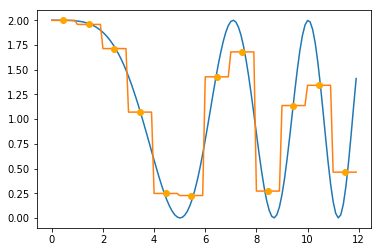

In [26]:
res1 = 0.1
res2 = 1.
ratio21 = int(res2 / res1)
x1 = np.arange(0, 12, res1)
truth1 = func(x1)
x2 = np.mean(x1.reshape(-1, ratio21), axis=1)
truth2 = np.mean(truth1.reshape(-1, ratio21), axis=1)
truth21 = np.repeat(truth2.reshape((-1,1)), ratio21)
truth21.shape, truth1.shape
plt.plot(x1, truth1)
plt.plot(x1, truth21)
plt.plot(x2, truth2, "o", color="orange")

In [27]:
obs_x = np.array([4, 6, 8])
tree = cKDTree(x1.reshape((-1,1)))
dist, obs_ix = tree.query(obs_x.reshape((-1,1)))

In [28]:
maxr = 3
maxr_n = int(maxr / res1)
sigma = 14
operator = windows.general_gaussian(2 * maxr_n, 1.5, sigma)

Text(0.5, 1.0, 'Operator')

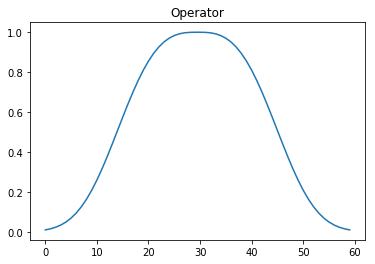

In [29]:
plt.plot(operator)
plt.title("Operator")

In [30]:
def forward(y, operator):
    return np.sum(operator * y) / np.sum(operator)

In [31]:
obs = [forward(truth21[ix-maxr_n:ix+maxr_n], operator) for ix in obs_ix]

In [32]:
x2ix_in_obs = []
for x_ in obs_x:
    x2ix_in_obs.append( np.where((x2 >= x_ - maxr) & (x2 < x_ + maxr))[0] )

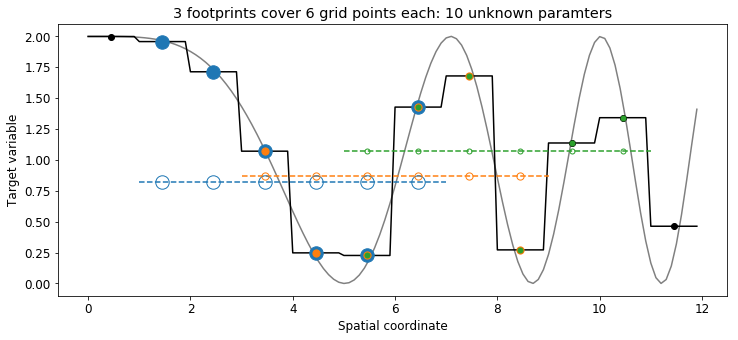

In [33]:
plt.figure(figsize=(12,5))
plt.rc('font', **{'size'   : 12})

plt.plot(x1, truth1, "-", color="grey")
plt.plot(x1, truth21, "-", color="black")
plt.plot(x2, truth2, "o", color="black")

cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, ix_ in enumerate(x2ix_in_obs):
    plt.plot(x2[ix_], truth2[ix_], ls="None", marker="o", ms=5*(len(x2ix_in_obs)/(i+1))**0.9, color=plt.cm.tab10(i) )
#plt.plot(x[obs_ix], truth[obs_ix], "ro")
#plt.plot(obs_x, obs, "go")
#truth2_mean = np.mean(truth21, axis=1)

#for i in range(len(x2)):
#    plt.plot([x2[i, 0], x2[i, -1]], [truth2_mean[i], truth2_mean[i]], color="green", marker="None")

for i, x_ in enumerate(obs_x):
    plt.plot([x_- maxr, x_ + maxr], [obs[i], obs[i]], ls="dashed", marker="None", color=plt.cm.tab10(i))

for i, ix_ in enumerate(x2ix_in_obs):
    plt.plot(x2[ix_], np.repeat(obs[i], len(ix_)), ls="None", marker="o", 
             ms=5*(len(x2ix_in_obs)/(i+1))**0.9, color=plt.cm.tab10(i), mfc="None" )

    
plt.xlabel("Spatial coordinate")
plt.ylabel("Target variable")
#plt.grid()
title = plt.title("3 footprints cover 6 grid points each: 10 unknown paramters")

Construct high-resolution data for individual footprints based on estimated values at grid points, so we can apply the operator again to our estimated distribution.

Initial estimate: all grid points inside one footprint have the same value as the observation.

Construct an initial container with one row for each probe and one column for each grid point in the entire domain.

In [37]:
est2 = np.zeros((len(obs_x), len(x2))) * np.nan
for i in range(len(obs)):
        est2[i, x2ix_in_obs[i]] = np.repeat(obs[i], len(x2ix_in_obs[i]))
print(np.round(est2, 2))
print("")
est2 = np.nanmean(est2, axis=0)
print(np.round(est2,2))

[[ nan 0.82 0.82 0.82 0.82 0.82 0.82  nan  nan  nan  nan  nan]
 [ nan  nan  nan 0.87 0.87 0.87 0.87 0.87 0.87  nan  nan  nan]
 [ nan  nan  nan  nan  nan 1.07 1.07 1.07 1.07 1.07 1.07  nan]]

[ nan 0.82 0.82 0.84 0.84 0.92 0.92 0.97 0.97 1.07 1.07  nan]


/home/maik/miniconda3/envs/cosmic-sense/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


Construct high-resolution data from estimate

In [38]:
est21 = np.repeat(est2.reshape((-1,1)), ratio21)
est21.shape

(120,)

Apply operator to high-resolution estimates

In [42]:
est21_as_obs = np.array([forward(est21[ix-maxr_n:ix+maxr_n], operator) for ix in obs_ix])
print("Estimated", est21_as_obs)
print("Observed ", obs)

Estimated [0.85177969 0.91291901 0.97863859]
Observed  [0.8171975517168989, 0.865951704041758, 1.0709153540962744]


In [43]:
def rmse(x, y):
    return np.sqrt(np.mean((x-y)**2))

In [44]:
rmse(obs, est21_as_obs)

0.06302606016183705

In [ ]:
est21_as_obs = [forward(item, operator) for item in est21]
print("Estimated", est21_as_obs)
print("Observed ", obs)

Get the error for each grid point in any region of overlap

In [ ]:
plt.figure(figsize=(12,5))
plt.rc('font', **{'size'   : 12})

line_hdtruth = plt.plot(x1, truth1, "-", color="grey", label="truth (HD)")
line_avgtruth = plt.plot(x1, truth21, "-", color="black", label="truth (AVG)")
#plt.plot(x2, truth2, "o", color="black", label="truth (AVG)")

cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, ix_ in enumerate(x2ix_in_obs):
    plt.plot(x2[ix_], truth2[ix_], ls="None", marker="o", ms=5*(len(x2ix_in_obs)/(i+1))**0.9, color=plt.cm.tab10(i) )
#plt.plot(x[obs_ix], truth[obs_ix], "ro")
#plt.plot(obs_x, obs, "go")
#truth2_mean = np.mean(truth21, axis=1)

#for i in range(len(x2)):
#    plt.plot([x2[i, 0], x2[i, -1]], [truth2_mean[i], truth2_mean[i]], color="green", marker="None")

for i, x_ in enumerate(obs_x):
    plt.plot([x_- maxr, x_ + maxr], [obs[i], obs[i]], ls="dashed", marker="None", color=plt.cm.tab10(i))

for i, ix_ in enumerate(x2ix_in_obs):
    plt.plot(x2[ix_], np.repeat(obs[i], len(ix_)), ls="None", marker="o", 
             ms=5*(len(x2ix_in_obs)/(i+1))**0.9, color=plt.cm.tab10(i), mfc="None" )

plt.plot(x2, est2, "o", color="black", mfc="None", ms=20, label="Estimate (AVG)")
    
plt.xlabel("Spatial coordinate")
plt.ylabel("Target variable")
#plt.grid()
title = plt.title("3 footprints cover 6 grid points each: 10 unknown parameters")
plt.legend()

## Next steps

- Reduce the number of parameters...somehow...without loss of information
- Include time series of observations with the objective to minimize variation in time for each grid point